In [5]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [7]:
from dotenv import load_dotenv
assert load_dotenv()

- `Who won the 2025 Champions League?`

In [10]:
llm = init_chat_model("openai:gpt-4o-mini")

In [15]:
class State(TypedDict):
    # 在 graph node 间数据流转，不断追加 messages
    # [human, ai(tool), ai, ...]
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

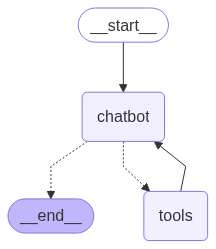

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
import uuid

In [14]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    events = graph.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config,
        stream_mode="values",
    )
    for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()

KeyboardInterrupt: Interrupted by user